# Домашнее задание 3

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_3

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [352]:
import numpy as np
import optimization as opt
from sklearn.datasets import load_svmlight_file
from matplotlib import pylab as plt
from sklearn.metrics import accuracy_score, mean_squared_error

## Задача 1

Вновь рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i).
\end{equation}

В прошлом задании работа шла с линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$. 

__(а)__ В дополнение к квадратичной функции потерь реализуйте логистическую/сигмоидную: $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Выпишите градиент. Является ли новая задача регресии выпуклой? Оцените $L$ для новой функции потерь. 

Пусть $x_i \in \mathbb{R}^d$ - ветор признаков для $i$-го элемента выборки. Тогда:

$$X = \begin{pmatrix}
        x_1^T \\
        \vdots \\
        x_n^T
      \end{pmatrix}$$
      
$$\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i) = \min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (w^Tx_i, y_i) = \min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ln (1 + \exp(-w^Tx_iy_i))$$

Перепишем $f(w)$:

$$f(w) = \frac{1}{n} \sum\limits_{i=1}^n \ln (1 + \exp(-w^Tx_iy_i))$$

Найдем $\nabla f(w)$:

$$\frac{\partial f(w)}{\partial w_k} = - \frac{1}{n} \sum\limits_{i=1}^n \frac{x_{ik} y_i \exp(-w^Tx_iy_i)}{1 + \exp(-w^Tx_iy_i)}$$

$$\nabla f(w) = - \frac{1}{n} \sum\limits_{i=1}^n \frac{y_i}{1 + \exp(w^Tx_iy_i)} x_i$$

Найдем $\nabla^2 f(w)$:

$$\frac{\partial f(w)}{\partial w_k \partial w_p} = \frac{1}{n} \sum\limits_{i=1}^n x_{ik} x_{ip} y_i^2 \frac{\exp(w^Tx_iy_i)}{(1 + \exp(w^Tx_iy_i))^2}$$

С учетом того, что $y_i$ принимает значения 1 и -1:

$$\nabla^2 f(w) = \frac{1}{n} \sum\limits_{i=1}^n \frac{\exp(w^Tx_iy_i)}{(1 + \exp(w^Tx_iy_i))^2} x_i x_i^T$$

$\nabla^2 f(w) \succeq 0$, так гессиан представляется в виде суммы положительно полуопределеенных матриц, взятыми с положительными коэффициентами. Следовательно задача выпуклая.

Определим константу Липшица градиента, пользовался [этой статьей](https://www.eecis.udel.edu/~xwu/class/ELEG867/Lecture9.pdf):

$$\| \nabla f(w) - \nabla f(v) \|_2 \leq L \| w - v \|_2$$

$$\| \nabla f(w) \|_2^2 \leq 2L f(w)$$

Найдем константу Липшица для одномерной $g(z) = \ln(1 + \exp(-z))$:

$$g'(z) = - \frac{1}{1 + \exp{(z)}}$$

$$g''(z) = \frac{\exp{(z)}}{(1 + \exp{(z)})^2}$$

$$g'^2(z) \leq 2 L' g(z) \Rightarrow \frac{1}{2 L'} \leq (1 + \exp{(z)})^2 \ln(1 + \exp(-z)) \Rightarrow \frac{1}{2 L'} \leq \frac{4}{2} \Rightarrow L' \geq \frac{1}{4}$$

$$\| \nabla f(w) - \nabla f(v) \|_2 = \left \| \frac{1}{n} \sum\limits_{i=1}^n \frac{y_i}{1 + \exp(w^Tx_iy_i)} x_i - \frac{1}{n} \sum\limits_{i=1}^n \frac{y_i}{1 + \exp(v^Tx_iy_i)} x_i \right\|_2 = \frac{1}{n} \left \| \sum\limits_{i=1}^n \left( \frac{1}{1 + \exp(w^Tx_iy_i)} - \frac{1}{1 + \exp(v^Tx_iy_i)} \right) y_i x_i \right\|_2 \leq \frac{1}{n} \left \| \sum\limits_{i=1}^n \frac{1}{4} \| w^Tx_iy_i - v^Tx_iy_i \|_2 y_i x_i \right\|_2 \leq \frac{1}{4n} \left \| \sum\limits_{i=1}^n \| w - v \|_2 \| y_i x_i \|_2^2 \right\|_2 = \frac{1}{4n} \left \| \sum\limits_{i=1}^n \| x_i \|_2^2 \right\|_2 \| w - v \|_2$$

$$L = \frac{1}{4} \max_i \|x_i\|_2^2$$

__(б)__ Возьмите датасет _mushrooms_ из прошлого задания. Проделайте следующие шаги из прошлого задания, только с логистической функцией потерь:

1) Разделите данные на две части: обучающую и тестовую.

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

1)Разделите данные на две части: обучающую и тестовую.

In [353]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape
y = 2 * y - 3

In [354]:
seed = 4

np.random.seed(seed)
np.random.shuffle(X)
X_train = X[:(n*4) // 5]
X_test = X[(n*4) // 5:]

np.random.seed(seed)
np.random.shuffle(y)
y_train = y[:(n*4) // 5]
y_test = y[(n*4) // 5:]

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

In [355]:
maximum = -1
for line in X_train:
    norm = np.linalg.norm(line, ord = 2)**2    
    if norm > maximum:
        maximum = norm
L = maximum / 4
print("L =", round(L, 2))

L = 5.25


3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

In [356]:
#Целевая функция
def f(w):
    s = 0
    for i in range(F.shape[0]):
        s += np.log(1 + np.exp(- w.T @ F[i] * a[i]))
    return 1 / F.shape[0] * s

#Градиент функции 
def grad_f(w):
    s = 0
    for i in range(F.shape[0]):
        s += 1 / (1 + np.exp(w.T @ F[i] * a[i])) * a[i] * F[i]
    return - 1 / F.shape[0] * s

crit - критерий сходимости:

0. crit = 0: $\left\| x^k - x^* \right\|_2^2$
1. crit = 1: $\left| f(x^k) - f(x^*)\right|$
2. crit = 2: $\left\| x^{k+1} - x^k \right\|_2^2$
3. crit = 3: $\left | f(x^{k+1}) - f(x^k) \right|$
4. crit = 4: $\left\| \nabla f(x^k) \right\|_2^2$

In [357]:
#Градиентный спуск из 1-го задания
def gradient_descent(grad_f, x_0, gamma, iteration, f, crit, x_sol=None, epsilon=10**-7):
    x_now = x_0
    errors = []
    for k in opt.progress(range(iteration)):
        x_next = x_now - gamma * grad_f(x_now)
        if crit == 0:
            err = np.linalg.norm(x_now - x_sol, ord = 2)**2
        elif crit == 1:
            err = f(x_now) - f(x_sol)
        elif crit == 2:
            err = np.linalg.norm(x_next - x_now, ord = 2)**2
        elif crit == 3:
            err = f(x_now) - f(x_next)
        elif crit == 4:
            err = np.linalg.norm(grad_f(x_now), ord = 2)**2
        x_now = x_next
        errors.append(err)
        if err < epsilon:
            break
    return x_now, errors

In [358]:
F = X_train
a = y_train

np.random.seed(8)
w_0 = np.random.sample(d)

In [360]:
w, errors = gradient_descent(grad_f, w_0, 1 / L, 1000, f, 4)
iterations = np.array(range(len(errors)))
print("f(w) = ", f(w))

f(w) =  0.04447374495606375


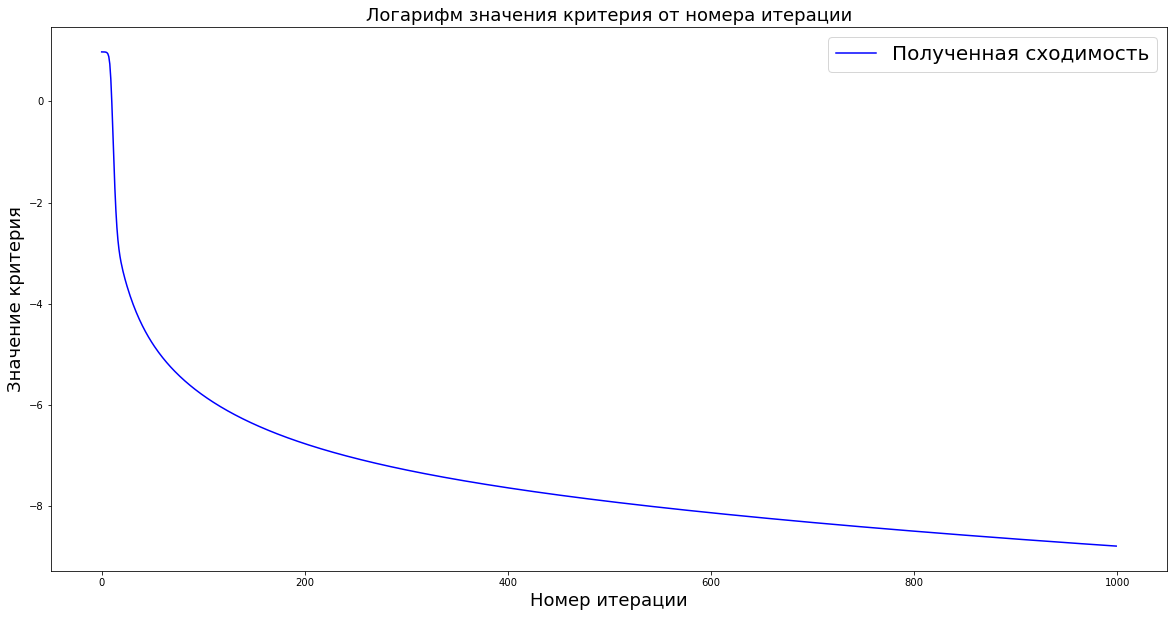

In [361]:
plt.figure(figsize = (20, 10))

plt.plot(iterations, np.log(errors), color = 'blue', label = 'Полученная сходимость')

plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Значение критерия", fontsize = 18)

plt.legend(fontsize = 20)
plt.show()

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

Проблем не возникло.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

In [362]:
y_pred = X_test @ w
for i in range(len(y_pred)):
    if y_pred[i] > 0:
        y_pred[i] = 1
    else:
        y_pred[i] = -1

print("Accuracy =", accuracy_score(y_test, y_pred))

Accuracy = 0.9913846153846154


In [363]:
def accuracy_graf_grad(y_test, X_test, grad_f, x_0, gamma, iteration, f, crit):
    accuracy = []
    for i in opt.progress(range(5, iteration + 1, 5)):
        w, _ = gradient_descent(grad_f, x_0, gamma, i, f, crit)
        y_pred = X_test @ w
        for i in range(len(y_pred)):
            if y_pred[i] > 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        accuracy.append(accuracy_score(y_test, y_pred))
    return accuracy

In [364]:
accuracy = accuracy_graf_grad(y_test, X_test, grad_f, w_0, 1 / L, 100, f, 4)
iterations = 5 * np.array(range(len(accuracy)))

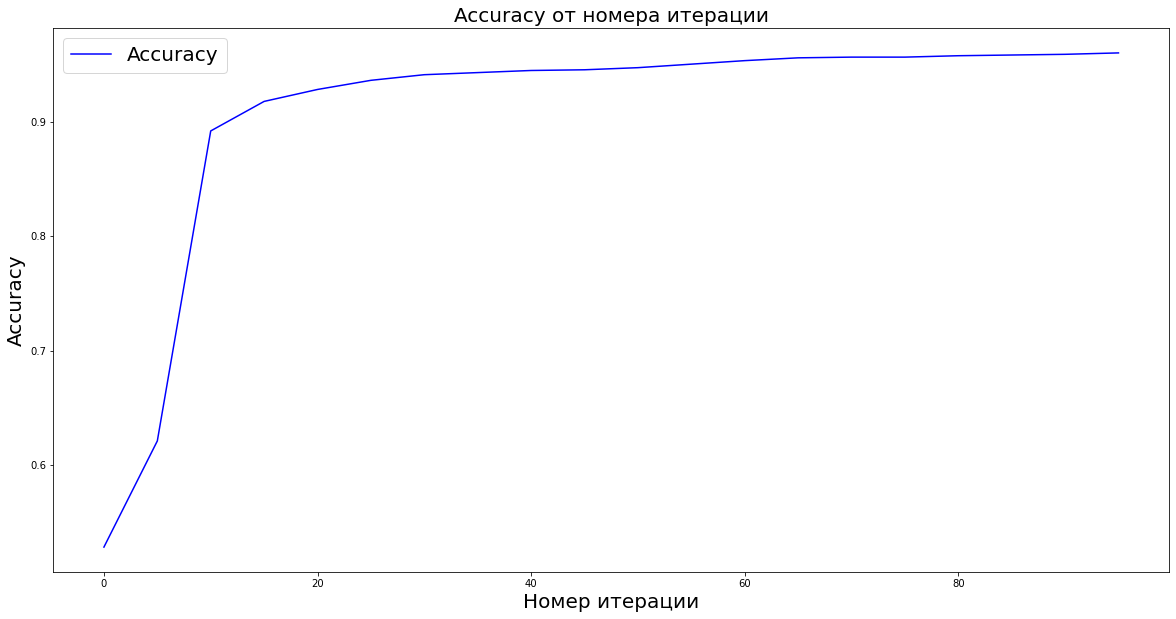

In [365]:
plt.figure(figsize = (20, 10))

plt.plot(iterations, accuracy, color = 'blue', label = 'Accuracy')

plt.title("Accuracy от номера итерации", fontsize = 20)
plt.xlabel("Номер итерации", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)

plt.legend(fontsize = 20)
plt.show()

Как мы видим метод с логистической функцией потерь работает примерно, как и сквадратичной функцией потерь. Accuracy получлось примерно одинаковым.

## Задача 2

__(a)__ Реализуйте метод тяжелого шарика. 

Метод тяжелого шарика: 

$$x^{k + 1} = x^k - \gamma \nabla (x^k) + \alpha (x^{k} - x^{k - 1})$$

crit - критерий сходимости:

0. crit = 0: $\left\| x^k - x^* \right\|_2^2$
1. crit = 1: $\left| f(x^k) - f(x^*)\right|$
2. crit = 2: $\left\| x^{k+1} - x^k \right\|_2^2$
3. crit = 3: $\left | f(x^{k+1}) - f(x^k) \right|$
4. crit = 4: $\left\| \nabla f(x^k) \right\|_2^2$

In [366]:
def heavy_ball(grad_f, x_0, gamma, alpha, iteration, f, crit, x_sol=None, epsilon=10**-7):
    x_now = x_0
    x_prev = x_0
    errors = []
    for k in opt.progress(range(iteration)):
        x_next = x_now + alpha * (x_now - x_prev) - gamma * grad_f(x_now)
        if crit == 0:
            err = np.linalg.norm(x_now - x_sol, ord = 2)**2
        elif crit == 1:
            err = f(x_now) - f(x_sol)
        elif crit == 2:
            err = np.linalg.norm(x_next - x_now, ord = 2)**2
        elif crit == 3:
            err = f(x_now) - f(x_next)
        elif crit == 4:
            err = np.linalg.norm(grad_f(x_now), ord = 2)**2
        x_help = x_now
        x_now = x_next
        x_prev = x_help
        errors.append(err)
        if err < epsilon:
            break
    return x_now, errors

__(б)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

In [367]:
errors = []
iterations = []
colors = ["orange", "blue", "green", "red", "cyan", "purple", "pink", "gray"]
alphas = [-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.8, 0.9]

for alpha in opt.progress(alphas): 
    _, error = heavy_ball(grad_f, w_0, 1 / L, alpha, 400, f, 4)
    errors.append(error)
    iteration = np.array(range(len(error)))
    iterations.append(iteration)

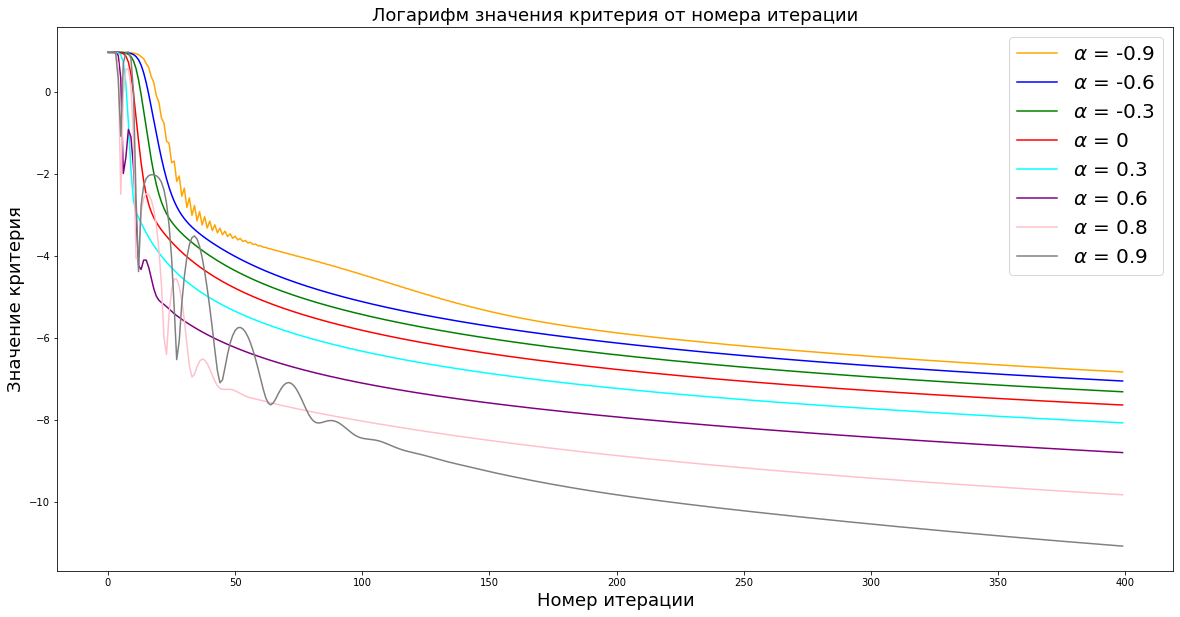

In [368]:
plt.figure(figsize = (20, 10))

for iteration, error, color, alpha in zip(iterations, errors, colors, alphas):
    plt.plot(iteration, np.log(error), color, label = r"$\alpha$ = " + str(alpha))

plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Значение критерия", fontsize = 18)

plt.legend(fontsize = 20)
plt.show()

Как мы видим для положительных $\alpha$ сходимость не является монотонной, но достаточно быстро превращается в монотонную. Оптимальнее всего будет взять $\alpha = 0.8$, так как хорошая скороть сходимости и не очень сильные колебания.

__(в)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

In [369]:
def accuracy_graf_ball(y_test, X_test, grad_f, x_0, gamma, alpha, iteration, f, crit):
    accuracy = []
    for i in opt.progress(range(5, iteration + 1, 5)):
        w, _ = heavy_ball(grad_f, x_0, gamma, alpha, i, f, crit)
        y_pred = X_test @ w
        for i in range(len(y_pred)):
            if y_pred[i] > 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        accuracy.append(accuracy_score(y_test, y_pred))
    return accuracy

In [391]:
accuracy_1 = accuracy_graf_grad(y_test, X_test, grad_f, w_0, 1 / L, 100, f, 4)
iterations_1 = 5 * np.array(range(len(accuracy_1)))

accuracy_2 = accuracy_graf_ball(y_test, X_test, grad_f, w_0, 1 / L, 0.8, 100, f, 4)
iterations_2 = 5 * np.array(range(len(accuracy_2)))

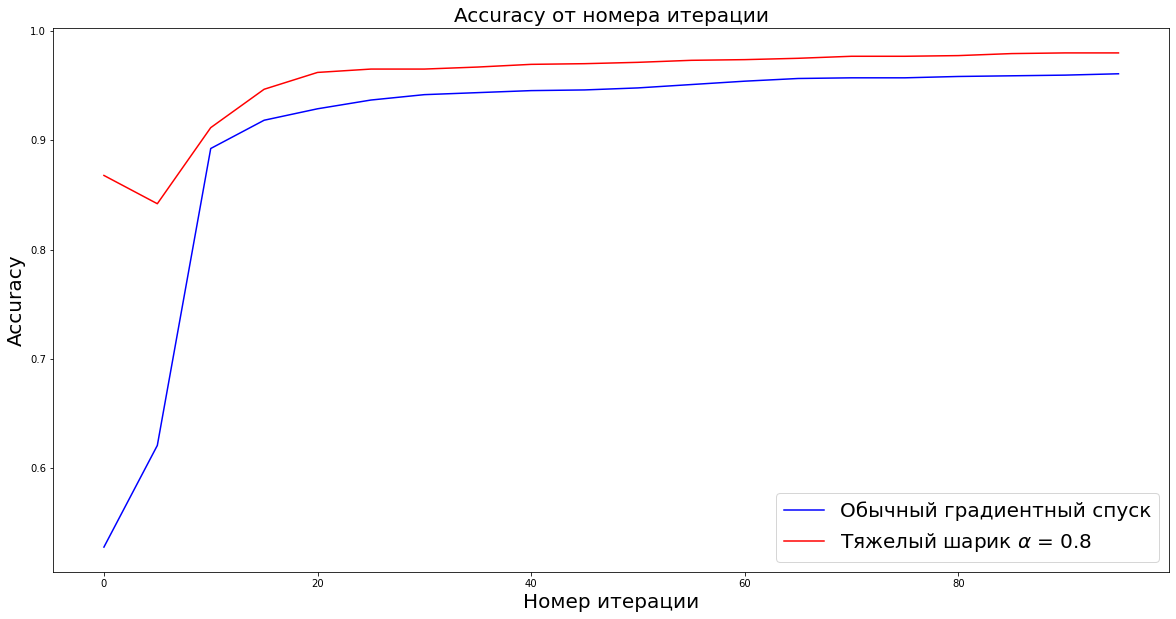

In [392]:
plt.figure(figsize = (20, 10))

plt.plot(iterations_1, accuracy_1, color = 'blue', label = 'Обычный градиентный спуск')
plt.plot(iterations_2, accuracy_2, color = 'red', label = r'Тяжелый шарик $\alpha$ = 0.8')

plt.title("Accuracy от номера итерации", fontsize = 20)
plt.xlabel("Номер итерации", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)

plt.legend(fontsize = 20)
plt.show()

Как мы видим метод тяжелого шарика сходится быстрее и точнее, чем обычный градиентный спуск.

__(г)__ Если в пунктах (б) и (в) столкнулись с проблемами, попробуйте $\ell_2$-регуляризовать задачу или рассмотреть ее на ограниченном множестве.

Проблем не возникло

__(д)__ Реализуйте ускоренный метод Нестерова (в форме Нестерова, а не который доказывали на семинаре). 

$$y^k = x^k + \eta(x^k - x^{k-1})$$

$$x^{k+1} = y^k - \gamma \nabla f(y^k)$$

In [372]:
def Nesterov_method(grad_f, x_0, gamma, eta, iteration, f, crit, x_sol=None, epsilon=10**-7):
    x_now = x_0
    x_prev = x_0
    errors = []
    for k in opt.progress(range(iteration)):
        x_next = x_now + eta(k) * (x_now - x_prev) - gamma * grad_f(x_now + eta(k) * (x_now - x_prev))
        if crit == 0:
            err = np.linalg.norm(x_now - x_sol, ord = 2)**2
        elif crit == 1:
            err = f(x_now) - f(x_sol)
        elif crit == 2:
            err = np.linalg.norm(x_next - x_now, ord = 2)**2
        elif crit == 3:
            err = f(x_now) - f(x_next)
        elif crit == 4:
            err = np.linalg.norm(grad_f(x_now), ord = 2)**2
        x_help = x_now
        x_now = x_next
        x_prev = x_help
        errors.append(err)
        if err < epsilon:
            break
    return x_now, errors

__(е)__ Решите задачу логистической регресии с помощью метода Нестерова (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

In [373]:
def eta_iter(index):
    def eta(k):
        return k / (k + index)
    return eta

In [374]:
def eta_const(nu):
    def eta(k):
        return nu
    return eta

In [388]:
colors_1 = ["orange", "green", "red", "cyan"] 
errors_1 = []
iterations_1 = []
etas = [-0.3, 0, 0.4, 0.8]
for eta in opt.progress(etas): 
    _, error = Nesterov_method(grad_f, w_0, 1 / L, eta_const(eta), 400, f, 4)
    errors_1.append(error)
    iteration = np.array(range(len(error)))
    iterations_1.append(iteration)

colors_2 = ["purple", "pink", "gray"]
errors_2 = []
iterations_2 = []
numbers = [1, 2, 3]

for number in opt.progress(numbers): 
    _, error = Nesterov_method(grad_f, w_0, 1 / L, eta_iter(number), 400, f, 4)
    errors_2.append(error)
    iteration = np.array(range(len(error)))
    iterations_2.append(iteration)

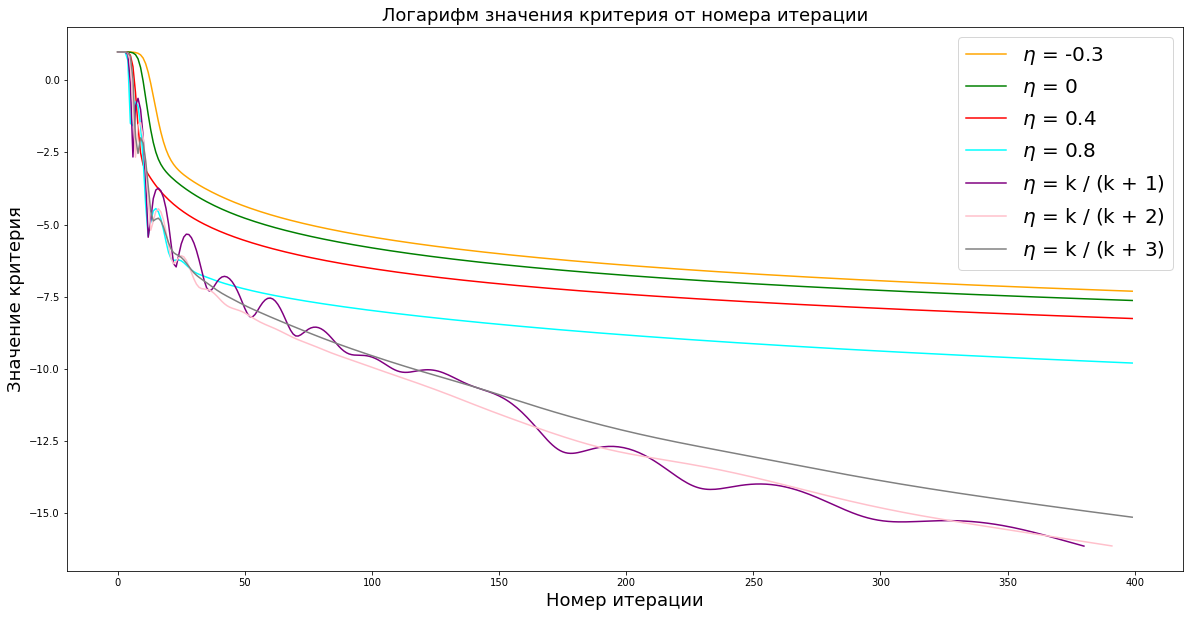

In [389]:
plt.figure(figsize = (20, 10))

for iteration, error, color, eta in zip(iterations_1, errors_1, colors_1, etas):
    plt.plot(iteration, np.log(error), color, label = r"$\eta$ = " + str(eta))

for iteration, error, color, number in zip(iterations_2, errors_2, colors_2, numbers):
    plt.plot(iteration, np.log(error), color, label = r"$\eta$ = k / (k + " + str(number) + r")")

plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Значение критерия", fontsize = 18)

plt.legend(fontsize = 20)
plt.show()

Как мы видим для положительных $\eta$ сходимость не является монотонной, но достаточно быстро превращается в монотонную. Оптимальнее всего будет взять $\eta = \frac{k}{k + 2}$, так как хорошая скороть сходимости и не очень сильные колебания.

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта (г). Сделайте итоговый вывод.

In [390]:
def accuracy_graf_Nesterov(y_test, X_test, grad_f, x_0, gamma, eta, iteration, f, crit):
    accuracy = []
    for i in opt.progress(range(5, iteration + 1, 5)):
        w, _ = Nesterov_method(grad_f, x_0, gamma, eta, i, f, crit)
        y_pred = X_test @ w
        for i in range(len(y_pred)):
            if y_pred[i] > 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        accuracy.append(accuracy_score(y_test, y_pred))
    return accuracy

In [394]:
accuracy_1 = accuracy_graf_Nesterov(y_test, X_test, grad_f, w_0, 1 / L, eta_iter(2), 100, f, 4)
iterations_1 = 5 * np.array(range(len(accuracy_1)))

accuracy_2 = accuracy_graf_grad(y_test, X_test, grad_f, w_0, 1 / L, 100, f, 4)
iterations_2 = 5 * np.array(range(len(accuracy_2)))

accuracy_3 = accuracy_graf_ball(y_test, X_test, grad_f, w_0, 1 / L, 0.8, 100, f, 4)
iterations_3 = 5 * np.array(range(len(accuracy_3)))

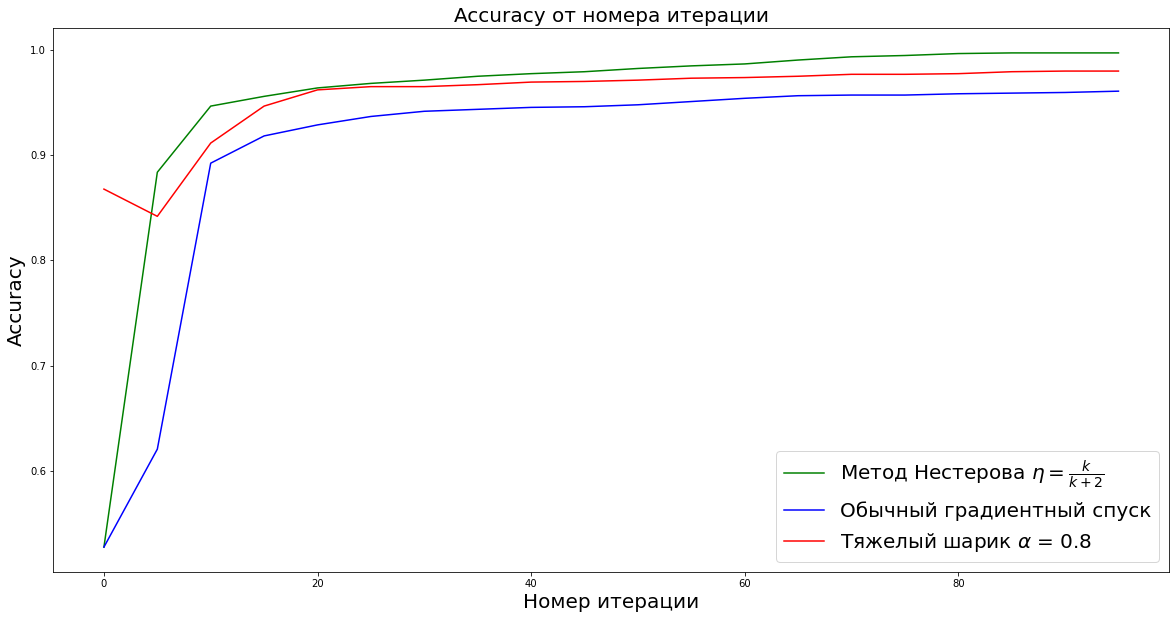

In [395]:
plt.figure(figsize = (20, 10))

plt.plot(iterations_1, accuracy_1, color = 'green', label = r'Метод Нестерова $\eta = \frac{k}{k + 2}$')
plt.plot(iterations_2, accuracy_2, color = 'blue', label = 'Обычный градиентный спуск')
plt.plot(iterations_3, accuracy_3, color = 'red', label = r'Тяжелый шарик $\alpha$ = 0.8')

plt.title("Accuracy от номера итерации", fontsize = 20)
plt.xlabel("Номер итерации", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)

plt.legend(fontsize = 20)
plt.show()

Задача с логистической функцией потерь хорошо решается обычным градиентым спуском, примерно также как и с квадратичной функцией потерь.

Методы тяжёлого шарика и Нестерова увеличивают скорость сходимости и точность по сравнению с обычным градиентным спуском, но на небольшом числе итераций ведут себя не монотонно. 

Метод Нестерова сходится быстрее, чем метод тяжёлого шарика, к тому же еще и точнее.

__Бонусные пункт__

__(з)__ Сделаем подбор константы $L$ адаптивным. Как упоминалось на семинаре, можно измерять локальную $L$, используя:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
В частности, может подойти процедура:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```

Каким стоит взять __h__? __rho__ должно быть больше или меньше 1? __L0__ надо брать заведомо большим или маленьким?

In [ ]:
#ответ

__(и)__ Поэксперементируйте с этой процедурой, встроенной в подбор $L$ для шага градиентного спуска. В качестве задачи продолжайте рассматривать логистическую регрессию из Задачи 1. Аналогично встройте процедуру подбора $L$ в метод тяжелого шарика и ускоренный метод Нестерова. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно). Отобразите на этом графике градиентный спуск, тяжелый шарик и метод Нестерова с адаптивным шагом и шагом $\frac{1}{L}$ (всего 6 линий на графике). Сделайте вывод.

In [ ]:
#ответ

__(к)__ Постройте аналогичный пункту (и) график точности модели от времени.

In [ ]:
#ответ

__(л)__ В [работе](https://arxiv.org/pdf/1204.3982.pdf) представлена техника рестартов для подавления немонотонной сходимости Алгоритма 2 (метод Нестерова). Попробуйте повторить эксперименты авторов на $\ell_2$-регуляризованной квадратичной или логистической регресии. Возьмите параметр регуляризации $\lambda = L / 100$.

In [ ]:
#ответ